Missing values in Review Text: 845
Missing values in Rating: 0
Missing values in Recommended IND: 0
Tokenizing reviews with spaCy...
Tokenization complete.
Creating features from tokenized text...
Number of text features: 5000
Training models...

Rating Prediction Results:
Mean Squared Error: 0.7705
Exact Match Accuracy: 0.5348

Recommended IND Prediction Results:
Accuracy: 0.8607
              precision    recall  f1-score   support

           0       0.82      0.28      0.42       812
           1       0.86      0.99      0.92      3717

    accuracy                           0.86      4529
   macro avg       0.84      0.64      0.67      4529
weighted avg       0.86      0.86      0.83      4529


Top 10 words for Rating prediction:
            feature  importance
3601         return    0.069951
1401   disappointed    0.029628
3166        perfect    0.025093
4672  unfortunately    0.020430
895           cheap    0.017495
2617           love    0.016822
4667   unflattering    0.015

c:\Users\mynam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\mynam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


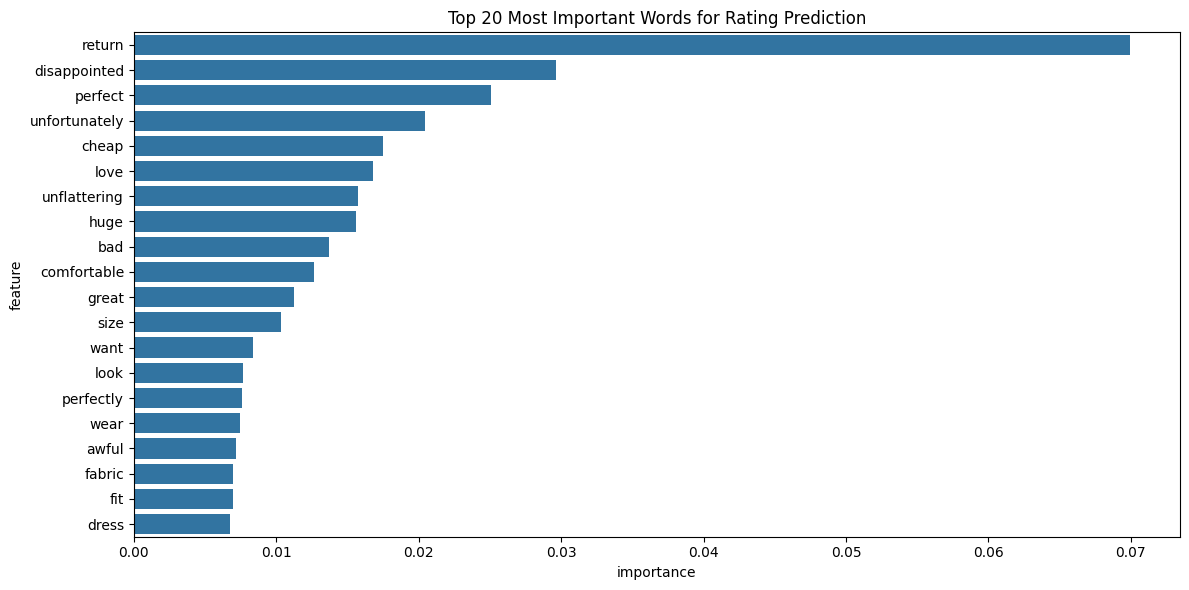

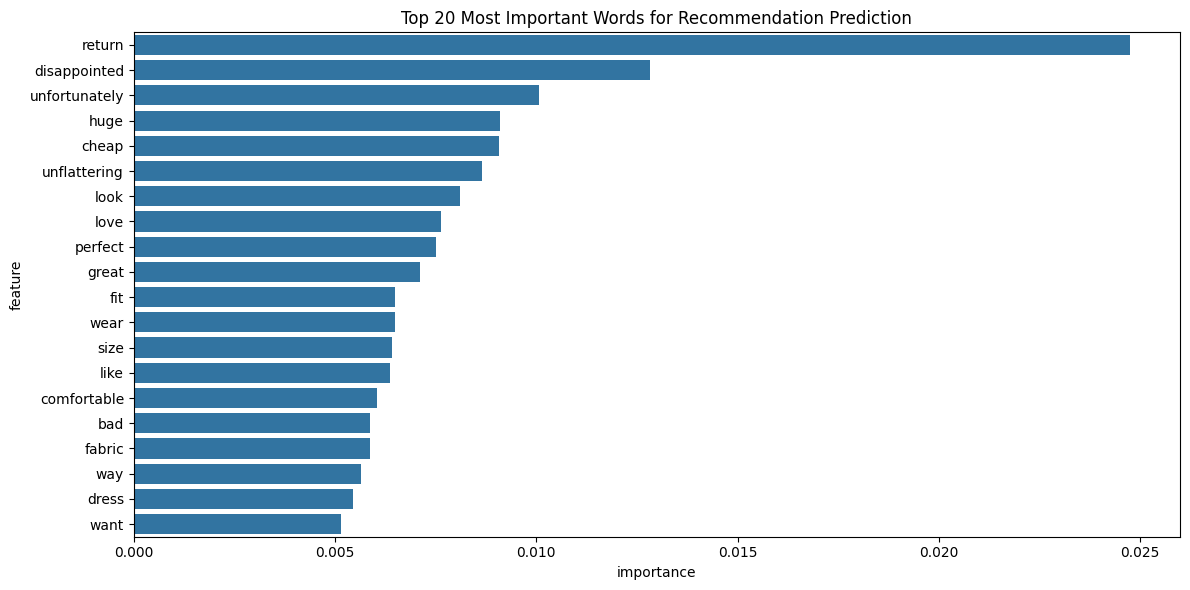

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

# Check for missing values in the columns we'll use
print("Missing values in Review Text:", df['Review Text'].isnull().sum())
print("Missing values in Rating:", df['Rating'].isnull().sum())
print("Missing values in Recommended IND:", df['Recommended IND'].isnull().sum())

# Drop rows with missing values in these columns
df = df.dropna(subset=['Review Text', 'Rating', 'Recommended IND'])

# Load spaCy English model
nlp = spacy.load('en_core_web_sm')

# Function to process text with spaCy
def process_text(text):
    doc = nlp(text)
    # Extract lemmatized tokens (excluding stopwords and punctuation)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

# Apply spaCy processing to review text (this may take some time)
print("Tokenizing reviews with spaCy...")
df['processed_text'] = df['Review Text'].apply(process_text)
print("Tokenization complete.")

# Create features using CountVectorizer on processed text
print("Creating features from tokenized text...")
vectorizer = CountVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['processed_text'])

# Get feature names
feature_names = vectorizer.get_feature_names_out()
print(f"Number of text features: {len(feature_names)}")

# Convert to DataFrame for easier handling
X_text_df = pd.DataFrame(X_text.toarray(), columns=feature_names)

# Split the data into training and testing sets
X_train, X_test, y_train_rating, y_test_rating, y_train_rec, y_test_rec = train_test_split(
    X_text_df, 
    df['Rating'], 
    df['Recommended IND'],
    test_size=0.2, 
    random_state=42
)

print("Training models...")

# 1. Model for Rating prediction (1-5)
rating_model = RandomForestRegressor(n_estimators=100, random_state=42)
rating_model.fit(X_train, y_train_rating)

# 2. Model for Recommended IND prediction (0 or 1)
rec_model = RandomForestClassifier(n_estimators=100, random_state=42)
rec_model.fit(X_train, y_train_rec)

# Evaluate Rating model
rating_preds = rating_model.predict(X_test)
rating_preds_rounded = np.round(rating_preds).clip(1, 5)  # Ensure predictions are between 1-5
mse = mean_squared_error(y_test_rating, rating_preds)
exact_accuracy = accuracy_score(y_test_rating, rating_preds_rounded)

print("\nRating Prediction Results:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Exact Match Accuracy: {exact_accuracy:.4f}")

# Evaluate Recommended IND model
rec_preds = rec_model.predict(X_test)
rec_accuracy = accuracy_score(y_test_rec, rec_preds)
print("\nRecommended IND Prediction Results:")
print(f"Accuracy: {rec_accuracy:.4f}")
print(classification_report(y_test_rec, rec_preds))

# Feature importance for Rating model
rating_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rating_model.feature_importances_
})
rating_importance = rating_importance.sort_values('importance', ascending=False).head(20)

# Feature importance for Recommendation model
rec_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rec_model.feature_importances_
})
rec_importance = rec_importance.sort_values('importance', ascending=False).head(20)

# Plot feature importance for Rating
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=rating_importance)
plt.title('Top 20 Most Important Words for Rating Prediction')
plt.tight_layout()
plt.savefig('rating_feature_importance.png')

# Plot feature importance for Recommendation
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=rec_importance)
plt.title('Top 20 Most Important Words for Recommendation Prediction')
plt.tight_layout()
plt.savefig('recommendation_feature_importance.png')

print("\nTop 10 words for Rating prediction:")
print(rating_importance.head(10))

print("\nTop 10 words for Recommendation prediction:")
print(rec_importance.head(10))

# Function to predict for new reviews
def predict_from_review(review_text):
    # Process the text
    processed = process_text(review_text)
    # Vectorize
    vector = vectorizer.transform([processed])
    # Predict
    rating = rating_model.predict(vector)[0]
    recommended = rec_model.predict(vector)[0]
    return {
        'predicted_rating': round(rating, 1),
        'predicted_recommendation': 'Recommended' if recommended == 1 else 'Not Recommended'
    }

# Example usage
example_review = "This dress is amazing! The fit is perfect and the material is high quality."
predictions = predict_from_review(example_review)
print("\nPredictions for example review:")
print(f"Review: {example_review}")
print(f"Predicted Rating: {predictions['predicted_rating']}")
print(f"Predicted Recommendation: {predictions['predicted_recommendation']}")